In [1]:
import pandas as pd
import numpy as np
import csv
from bs4 import BeautifulSoup
import requests
import xlrd
import json
import math
from scipy import interpolate
import warnings
warnings.simplefilter(action='ignore')
import os 
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [2]:
#Getting StationId,City,State mapping
file = '../Raw/stations.csv'
df_stations = pd.read_csv(file)
df_stations.drop(['StationName',"Status"],axis=1,inplace=True)
df_stations.drop_duplicates(inplace=True,ignore_index=True)
df_stations

,StationId,City,State
0,AP001,Amaravati,Andhra Pradesh
1,AP002,Rajamahendravaram,Andhra Pradesh
2,AP003,Tirupati,Andhra Pradesh
3,AP004,Vijayawada,Andhra Pradesh
4,AP005,Visakhapatnam,Andhra Pradesh
...,...,...,...
225,WB010,Kolkata,West Bengal
226,WB011,Kolkata,West Bengal
227,WB012,Kolkata,West Bengal
228,WB013,Kolkata,West Bengal


# Data cleaning of 2015-2020 values

In [3]:
#daily values of stations from 2015
file_s = '../Raw/station_day.csv'
df_station_d = pd.read_csv(file_s,parse_dates=["Date"])

In [4]:
#merging station daily values with their city and state names
df_station_day=pd.merge(df_stations,df_station_d,how="inner",left_on="StationId",right_on="StationId")
df_station_day["year"]=df_station_day.Date.dt.year
df_station_day

,StationId,City,State,Date,PM2.5,PM10,NO,NO2,NOx,NH3,CO,SO2,O3,Benzene,Toluene,Xylene,AQI,AQI_Bucket,year
0,AP001,Amaravati,Andhra Pradesh,2017-11-24,71.36,115.75,1.75,20.65,12.40,12.19,0.10,10.76,109.26,0.17,5.92,0.10,NaN,NaN,2017
1,AP001,Amaravati,Andhra Pradesh,2017-11-25,81.40,124.50,1.44,20.50,12.08,10.72,0.12,15.24,127.09,0.20,6.50,0.06,184.0,Moderate,2017
2,AP001,Amaravati,Andhra Pradesh,2017-11-26,78.32,129.06,1.26,26.00,14.85,10.28,0.14,26.96,117.44,0.22,7.95,0.08,197.0,Moderate,2017
3,AP001,Amaravati,Andhra Pradesh,2017-11-27,88.76,135.32,6.60,30.85,21.77,12.91,0.11,33.59,111.81,0.29,7.63,0.12,198.0,Moderate,2017
4,AP001,Amaravati,Andhra Pradesh,2017-11-28,64.18,104.09,2.56,28.07,17.01,11.42,0.09,19.00,138.18,0.17,5.02,0.07,188.0,Moderate,2017
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
108030,WB013,Kolkata,West Bengal,2020-06-27,8.65,16.46,NaN,NaN,NaN,NaN,0.69,4.36,30.59,1.32,7.26,NaN,50.0,Good,2020
108031,WB013,Kolkata,West Bengal,2020-06-28,11.80,18.47,NaN,NaN,NaN,NaN,0.68,3.49,38.95,1.42,7.92,NaN,65.0,Satisfactory,2020
108032,WB013,Kolkata,West Bengal,2020-06-29,18.60,32.26,13.65,200.87,214.20,11.40,0.78,5.12,38.17,3.52,8.64,NaN,63.0,Satisfactory,2020
108033,WB013,Kolkata,West Bengal,2020-06-30,16.07,39.30,7.56,29.13,36.69,29.26,0.69,5.88,29.64,1.86,8.40,NaN,57.0,Satisfactory,2020


In [5]:
#null values in station day
print(len(df_station_day))
df_station_day.isnull().sum()

108035


StationId         0
City              0
State             0
Date              0
PM2.5         21625
PM10          42706
NO            17106
NO2           16547
NOx           15500
NH3           48105
CO            12998
SO2           25204
O3            25568
Benzene       31455
Toluene       38702
Xylene        85137
AQI           21010
AQI_Bucket    21010
year              0
dtype: int64

In [6]:
#dropping Benzene,Xylene,Toluene,NH3 and PM10 as they have morethan 25% null values
df_station_day.drop(["Benzene","Xylene","Toluene","NH3","PM10","AQI_Bucket","O3","NOx"],axis=1,inplace=True)

In [7]:
#function to extrapolate station wise values

def f1(ct,tot_yrs):
    ct.reset_index(drop=True,inplace=True)
    state_name  = ct['State'].unique()
    st_name  = ct['StationId'].unique()
    ct_name  = ct['City'].unique()

    tot_yr=tot_yrs
    
    yr = ct['year'].values
    if len(yr)==1:
        return ct
   
    absent_yr = [i for i in tot_yr if i not in yr]
    f_s02 = interpolate.interp1d(ct['year'],ct['SO2'],kind='nearest',fill_value = "extrapolate")
    f_n02 = interpolate.interp1d(ct['year'],ct['NO2'],kind='nearest',fill_value = "extrapolate")
    f_pm25 = interpolate.interp1d(ct['year'],ct['PM2.5'],kind='nearest',fill_value = "extrapolate")
    
   
    x_new_s02 = [f_s02(i) for i in absent_yr]
    x_new_n02 = [f_n02(i) for i in absent_yr]
    x_new_pm25 = [f_pm25(i) for i in absent_yr]
    
    #plt.plot(ct['year'],ct['SO2'],absent_yr,x_new_s02,'*')
    
    for i in range(len(x_new_s02)):
        ct.loc[len(ct.index)] = [state_name[0],ct_name[0],st_name[0],absent_yr[i],x_new_s02[i],x_new_n02[i],x_new_pm25[i]]
        
    return ct

<AxesSubplot:>

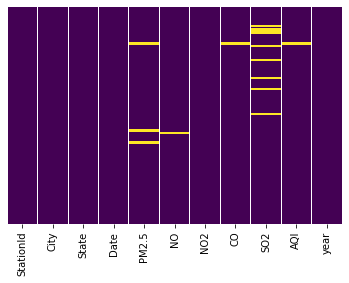

In [8]:
#groupby stationid and then interpoalte linearly
df_station_day=df_station_day.groupby(by=["StationId"]).apply(lambda group: group.interpolate(method='index',limit_direction='both'))

#heatmap for null values
sns.heatmap(df_station_day.isnull(),yticklabels=False,cbar=False,cmap='viridis')


<AxesSubplot:>

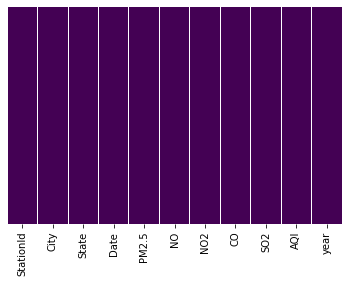

In [9]:
#groupby city and interpolate linearly
df_station_day=df_station_day.groupby(by=["City"]).apply(lambda group: group.interpolate(method='index',limit_direction='both'))

#heatmap for null values
sns.heatmap(df_station_day.isnull(),yticklabels=False,cbar=False,cmap='viridis')

<AxesSubplot:>

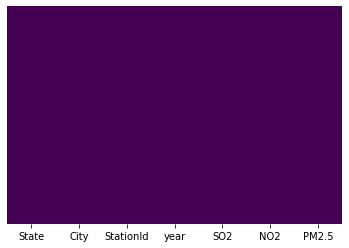

In [10]:
#annual mean of StationId values 
df_station_day = df_station_day.groupby(['StationId','City',"State","year"],as_index=False).mean()
df_test=df_station_day[['State','City','StationId','year','SO2','NO2','PM2.5']]

#heatmap for null values
sns.heatmap(df_test.isnull(),yticklabels=False,cbar=False,cmap='viridis')

In [11]:
#extrapolating the station data for unavailable years
df_2015_final=pd.DataFrame()
for i in df_test["StationId"].unique():
    tot_yrs=[2020,2019,2018,2017,2016,2015]
    fun=f1(df_test[df_test["StationId"]==i],tot_yrs)
    fun.sort_values(by=['year'],inplace=True)
    df_2015_final=pd.concat([df_2015_final,fun])
    
df_2015_final

,State,City,StationId,year,SO2,NO2,PM2.5
5,Andhra Pradesh,Amaravati,AP001,2015,15.101842105263161,37.028684210526315,84.00605263157894
4,Andhra Pradesh,Amaravati,AP001,2016,15.101842105263161,37.028684210526315,84.00605263157894
0,Andhra Pradesh,Amaravati,AP001,2017,15.101842,37.028684,84.006053
1,Andhra Pradesh,Amaravati,AP001,2018,12.181411,26.378795,37.663836
2,Andhra Pradesh,Amaravati,AP001,2019,15.50989,21.805384,35.875384
...,...,...,...,...,...,...,...
4,West Bengal,Kolkata,WB013,2016,9.852086466165412,43.11603383458646,55.01498120300754
3,West Bengal,Kolkata,WB013,2017,9.852086466165412,43.11603383458646,55.01498120300754
0,West Bengal,Kolkata,WB013,2018,9.852086,43.116034,55.014981
1,West Bengal,Kolkata,WB013,2019,7.27589,49.245096,60.191863


In [12]:
df_2015_final["SO2"]=df_2015_final["SO2"].astype(float)
df_2015_final["NO2"]=df_2015_final["NO2"].astype(float)
df_2015_final["PM2.5"]=df_2015_final["PM2.5"].astype(float)
df_2015_final.dtypes

State         object
City          object
StationId     object
year           int64
SO2          float64
NO2          float64
PM2.5        float64
dtype: object

In [13]:
#mean of annual city wise values
df_2015_final = df_2015_final.groupby(["State",'City',"year"],as_index=False).mean()

In [14]:
df_2015_final[df_2015_final.isnull().any(axis=1)]

,State,City,year,SO2,NO2,PM2.5


In [15]:
df_2015_final["City"].value_counts()
#df_2015_final["year"].unique()

Jorapokhar            6
Thiruvananthapuram    6
Talcher               6
Chennai               6
Chandigarh            6
Gurugram              6
Lucknow               6
Shillong              6
Hyderabad             6
Jaipur                6
Kolkata               6
Amaravati             6
Guwahati              6
Bengaluru             6
Coimbatore            6
Delhi                 6
Amritsar              6
Bhopal                6
Mumbai                6
Brajrajnagar          6
Visakhapatnam         6
Ahmedabad             6
Patna                 6
Kochi                 1
Aizawl                1
Ernakulam             1
Name: City, dtype: int64

# Data Preprocessing 1990-2015 data

In [16]:
#read 1990-2014 data file
df_2011=pd.read_csv('../Raw/data.csv',usecols=["stn_code","state","location","so2","no2","rspm","date"],parse_dates=["date"])

In [17]:
df_2011.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 435742 entries, 0 to 435741
Data columns (total 7 columns):
 #   Column    Non-Null Count   Dtype         
---  ------    --------------   -----         
 0   stn_code  291665 non-null  object        
 1   state     435742 non-null  object        
 2   location  435739 non-null  object        
 3   so2       401096 non-null  float64       
 4   no2       419509 non-null  float64       
 5   rspm      395520 non-null  float64       
 6   date      435735 non-null  datetime64[ns]
dtypes: datetime64[ns](1), float64(3), object(3)
memory usage: 23.3+ MB


In [18]:
#take data values not null
df_2011=df_2011[~df_2011["date"].isnull()]

df_2011["year"]=df_2011.date.dt.year

#rename columns
df_2011.columns=['StationId','State','City','SO2','NO2',"PM2.5",'Date','year']
df_2011

,StationId,State,City,SO2,NO2,PM2.5,Date,year
0,150.0,Andhra Pradesh,Hyderabad,4.8,17.4,NaN,1990-02-01,1990
1,151.0,Andhra Pradesh,Hyderabad,3.1,7.0,NaN,1990-02-01,1990
2,152.0,Andhra Pradesh,Hyderabad,6.2,28.5,NaN,1990-02-01,1990
3,150.0,Andhra Pradesh,Hyderabad,6.3,14.7,NaN,1990-03-01,1990
4,151.0,Andhra Pradesh,Hyderabad,4.7,7.5,NaN,1990-03-01,1990
...,...,...,...,...,...,...,...,...
435734,SAMP,West Bengal,ULUBERIA,20.0,44.0,148.0,2015-12-15,2015
435735,SAMP,West Bengal,ULUBERIA,17.0,44.0,131.0,2015-12-18,2015
435736,SAMP,West Bengal,ULUBERIA,18.0,45.0,140.0,2015-12-21,2015
435737,SAMP,West Bengal,ULUBERIA,22.0,50.0,143.0,2015-12-24,2015


<AxesSubplot:>

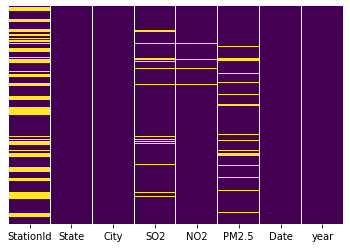

In [19]:
#heatmap of null values
sns.heatmap(df_2011.isnull(),yticklabels=False,cbar=False,cmap='viridis')

In [20]:
count = pd.DataFrame(df_2011["StationId"].value_counts())
count.reset_index(inplace=True)
count.columns=["StationId","Count"]
count=count[count["Count"]<=2]
count

,StationId,Count
794,112.0,2
795,208.0,2
796,205.0,2
797,560.0,2
798,53.0,2
799,207.0,1
800,209.0,1
801,224.0,1
802,275,1


In [21]:
single_stations = count["StationId"].tolist()
#single_stations
df_2011=df_2011[~df_2011["StationId"].isin(single_stations)]

<AxesSubplot:>

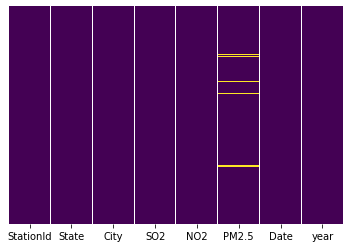

In [22]:
df_2011=df_2011.groupby(by=["StationId"]).apply(lambda group: group.interpolate(method='index',limit_direction='both'))

sns.heatmap(df_2011.isnull(),yticklabels=False,cbar=False,cmap='viridis')

<AxesSubplot:>

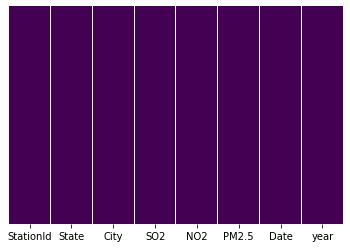

In [23]:
df_2011=df_2011.groupby(by=["City"]).apply(lambda group: group.interpolate(method='index',limit_direction='both'))
sns.heatmap(df_2011.isnull(),yticklabels=False,cbar=False,cmap='viridis')

<AxesSubplot:>

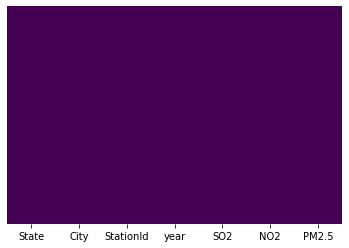

In [24]:
#stationid wise mean
df_2011 = df_2011.groupby(['StationId','City',"State","year"],as_index=False).mean()
df_2011=df_2011[['State','City','StationId','year','SO2','NO2','PM2.5']]
df_2011=df_2011[df_2011["year"]>2010]
sns.heatmap(df_2011.isnull(),yticklabels=False,cbar=False,cmap='viridis')

In [25]:
df_2011[df_2011["PM2.5"].isnull()]

,State,City,StationId,year,SO2,NO2,PM2.5


In [26]:
len(df_2011["City"].unique())

265

In [27]:
#extrapolating stationwise values
df_2011_final=pd.DataFrame()
for i in df_2011["StationId"].unique():
    tot_yrs=[2015,2014,2013,2012,2011]
    fun=f1(df_2011[df_2011["StationId"]==i],tot_yrs)
    fun.sort_values(by=['year'],inplace=True)
    df_2011_final=pd.concat([df_2011_final,fun])
    
df_2011_final

,State,City,StationId,year,SO2,NO2,PM2.5
0,Uttar Pradesh,Agra,1.0,2011,3.005747,18.314176,141.049808
0,Uttar Pradesh,Anpara,6.0,2011,16.116505,26.31068,139.660194
0,Uttar Pradesh,Renusagar,7.0,2011,16.349515,26.203883,140.15534
0,Rajasthan,Kota,17.0,2011,8.5,33.533333,163.666667
1,Rajasthan,Kota,17.0,2012,8.858762,33.740286,175.40819
...,...,...,...,...,...,...,...
3,West Bengal,DANKUNI,SAMP,2015,15.087379,43.679612,126.592233
2,Gujarat,Bhuj,SAMP,2015,13.375,20.708333,85.916667
1,Gujarat,Bharuch,SAMP,2015,13.416667,20.791667,83.416667
7,West Bengal,MALDAH,SAMP,2015,2.509615,16.346154,81.528846


In [28]:
df_2011_final["year"].value_counts()

2011    579
2015    569
2014    524
2013    524
2012    523
Name: year, dtype: int64

In [29]:
len(df_2011_final["City"].unique())

265

In [30]:
df_2011_final["SO2"]=df_2011_final["SO2"].astype(float)
df_2011_final["NO2"]=df_2011_final["NO2"].astype(float)
df_2011_final["PM2.5"]=df_2011_final["PM2.5"].astype(float)
df_2011_final.dtypes

State         object
City          object
StationId     object
year           int64
SO2          float64
NO2          float64
PM2.5        float64
dtype: object

In [31]:
df_2011_final = df_2011_final.groupby(["State",'City',"year"]).mean()
df_2011_final


SO2        NO2       PM2.5
State          City           year                                   
Andhra Pradesh Ananthapur     2011    4.000000  12.564815   70.009259
                              2012    4.000000  12.564815   70.009259
                              2013    4.000000  12.564815   70.009259
                              2014    4.787037  10.314815   75.990741
                              2015    5.166667  10.685185   87.907407
...                                        ...        ...         ...
West Bengal    South Suburban 2012  118.959360   8.278941   59.496305
                              2013    8.514492  59.551415  179.981492
                              2014    4.213592  37.762136   96.373786
                              2015    3.461632  36.880695   90.215366
               ULUBERIA       2015   14.615385  43.317308  124.826923

[1197 rows x 3 columns]

In [32]:
for year in range(2011,2016):
    df_2011_final.loc[('Delhi','Delhi',year)]=df_2011_final.loc[[('Delhi','Delhi',year),('Uttar Pradesh','Noida',year)]].mean()
df_2011_final.reset_index(inplace=True)

In [33]:
ts_cities=df_2011_final[df_2011_final["State"]=="Telangana"]["City"].unique()
for city in ts_cities:
    df_2011_final.loc[df_2011_final.City==city, 'State'] = "Telangana"

In [34]:
df_2011_final=df_2011_final.replace('Bangalore','Bengaluru')
df_2011_final

,State,City,year,SO2,NO2,PM2.5
0,Andhra Pradesh,Ananthapur,2011,4.000000,12.564815,70.009259
1,Andhra Pradesh,Ananthapur,2012,4.000000,12.564815,70.009259
2,Andhra Pradesh,Ananthapur,2013,4.000000,12.564815,70.009259
3,Andhra Pradesh,Ananthapur,2014,4.787037,10.314815,75.990741
4,Andhra Pradesh,Ananthapur,2015,5.166667,10.685185,87.907407
...,...,...,...,...,...,...
1192,West Bengal,South Suburban,2012,118.959360,8.278941,59.496305
1193,West Bengal,South Suburban,2013,8.514492,59.551415,179.981492
1194,West Bengal,South Suburban,2014,4.213592,37.762136,96.373786
1195,West Bengal,South Suburban,2015,3.461632,36.880695,90.215366


In [35]:
len(df_2011_final["City"].unique())

265

In [36]:
df_concat = pd.concat([df_2011_final,df_2015_final])
df_concat

,State,City,year,SO2,NO2,PM2.5
0,Andhra Pradesh,Ananthapur,2011,4.000000,12.564815,70.009259
1,Andhra Pradesh,Ananthapur,2012,4.000000,12.564815,70.009259
2,Andhra Pradesh,Ananthapur,2013,4.000000,12.564815,70.009259
3,Andhra Pradesh,Ananthapur,2014,4.787037,10.314815,75.990741
4,Andhra Pradesh,Ananthapur,2015,5.166667,10.685185,87.907407
...,...,...,...,...,...,...
136,West Bengal,Kolkata,2016,9.008383,37.962214,73.343433
137,West Bengal,Kolkata,2017,9.008383,37.962214,73.343433
138,West Bengal,Kolkata,2018,9.008383,37.962214,73.343433
139,West Bengal,Kolkata,2019,7.850325,34.554863,57.183125


In [37]:
df_concat = df_concat.groupby(["State",'City',"year"],as_index=False).mean()
df_concat

,State,City,year,SO2,NO2,PM2.5
0,Andhra Pradesh,Amaravati,2015,15.101842,37.028684,84.006053
1,Andhra Pradesh,Amaravati,2016,15.101842,37.028684,84.006053
2,Andhra Pradesh,Amaravati,2017,15.101842,37.028684,84.006053
3,Andhra Pradesh,Amaravati,2018,12.181411,26.378795,37.663836
4,Andhra Pradesh,Amaravati,2019,15.509890,21.805384,35.875384
...,...,...,...,...,...,...
1310,West Bengal,South Suburban,2012,118.959360,8.278941,59.496305
1311,West Bengal,South Suburban,2013,8.514492,59.551415,179.981492
1312,West Bengal,South Suburban,2014,4.213592,37.762136,96.373786
1313,West Bengal,South Suburban,2015,3.461632,36.880695,90.215366


In [38]:
def f2(ct):
    ct.reset_index(drop=True,inplace=True)
    state_name  = ct['State'].unique()
    ct_name  = ct['City'].unique()
    
    tot_yr = [2020,2019,2018,2017,2016,2015,2014,2013,2012,2011]
    
    yr = ct['year'].values
    if len(yr)==1:
        return ct
    absent_yr = [i for i in tot_yr if i not in yr]
    f_s02 = interpolate.interp1d(ct['year'],ct['SO2'],kind='linear',fill_value = "extrapolate")
    f_n02 = interpolate.interp1d(ct['year'],ct['NO2'],kind='linear',fill_value = "extrapolate")
    f_pm25 = interpolate.interp1d(ct['year'],ct['PM2.5'],kind='linear',fill_value = "extrapolate")
    
    x_new_s02 = [f_s02(i) for i in absent_yr]
    x_new_n02 = [f_n02(i) for i in absent_yr]
    x_new_pm25 = [f_pm25(i) for i in absent_yr]
    #print(x_new_s02)
    #plt.plot(ct['year'],ct['SO2'],absent_yr,x_new_s02,'*')
#     print(slinear
#     print(x_new_s02)
    
    for i in range(len(x_new_s02)):
        ct.loc[len(ct.index)] = [state_name[0],ct_name[0],absent_yr[i],x_new_s02[i],x_new_n02[i],x_new_pm25[i]]
    return ct

In [39]:
df_concat_final=pd.DataFrame()
for i in df_concat["City"].unique():
    fun=f2(df_concat[df_concat["City"]==i])
    fun.sort_values(by=['year'],inplace=True)
    df_concat_final=pd.concat([df_concat_final,fun])

In [40]:
df_concat_final["SO2"]=df_concat_final["SO2"].astype(float)
df_concat_final["NO2"]=df_concat_final["NO2"].astype(float)
df_concat_final["PM2.5"]=df_concat_final["PM2.5"].astype(float)
df_concat_final.dtypes

State     object
City      object
year       int64
SO2      float64
NO2      float64
PM2.5    float64
dtype: object

In [41]:
cities=df_2015_final["City"].unique()
cities_2011=df_2011_final["City"].unique()
city_common=[i for i in cities if i in cities_2011]
print(len(cities),len(cities_2011),len(city_common))
print(city_common)
df_cities=df_concat_final[df_concat_final["City"].isin(city_common)]
df_cities.reset_index(drop=True,inplace=True)
df_cities

26 265 21
['Visakhapatnam', 'Guwahati', 'Patna', 'Chandigarh', 'Delhi', 'Ahmedabad', 'Bengaluru', 'Kochi', 'Thiruvananthapuram', 'Bhopal', 'Mumbai', 'Shillong', 'Aizawl', 'Talcher', 'Amritsar', 'Jaipur', 'Chennai', 'Coimbatore', 'Hyderabad', 'Lucknow', 'Kolkata']


,State,City,year,SO2,NO2,PM2.5
0,Andhra Pradesh,Visakhapatnam,2011,12.756498,13.937977,63.729625
1,Andhra Pradesh,Visakhapatnam,2012,12.756498,13.937977,63.729625
2,Andhra Pradesh,Visakhapatnam,2013,13.341878,17.990052,67.876470
3,Andhra Pradesh,Visakhapatnam,2014,13.083952,20.222312,63.465834
4,Andhra Pradesh,Visakhapatnam,2015,15.184297,30.749601,52.832117
...,...,...,...,...,...,...
205,West Bengal,Kolkata,2016,9.008383,37.962214,73.343433
206,West Bengal,Kolkata,2017,9.008383,37.962214,73.343433
207,West Bengal,Kolkata,2018,9.008383,37.962214,73.343433
208,West Bengal,Kolkata,2019,7.850325,34.554863,57.183125


In [42]:
df_cities[df_cities["City"]=="Kochi"]

,State,City,year,SO2,NO2,PM2.5
70,Kerala,Kochi,2011,3.291752,12.763179,38.392155
71,Kerala,Kochi,2012,3.219947,9.927800,65.992069
72,Kerala,Kochi,2013,2.280156,6.059814,75.625917
73,Kerala,Kochi,2014,2.405146,8.597100,67.709221
74,Kerala,Kochi,2015,2.452647,11.391182,41.000591
75,Kerala,Kochi,2016,5.481315,12.018970,39.086176
76,Kerala,Kochi,2017,8.509983,12.646759,37.171762
77,Kerala,Kochi,2018,11.538651,13.274547,35.257347
78,Kerala,Kochi,2019,14.567319,13.902335,33.342933
79,Kerala,Kochi,2020,17.595988,14.530123,31.428519


In [43]:
df_cities["City"].value_counts()

Amritsar              10
Bhopal                10
Kolkata               10
Kochi                 10
Guwahati              10
Bengaluru             10
Coimbatore            10
Delhi                 10
Talcher               10
Chandigarh            10
Chennai               10
Thiruvananthapuram    10
Aizawl                10
Mumbai                10
Lucknow               10
Visakhapatnam         10
Ahmedabad             10
Shillong              10
Hyderabad             10
Patna                 10
Jaipur                10
Name: City, dtype: int64

In [44]:
df_states = df_concat_final.groupby(["State","year"],as_index=False).mean()
df_states.reset_index(drop=True,inplace=True)
df_states

,State,year,SO2,NO2,PM2.5
0,Andhra Pradesh,2011,6.917445,14.339150,70.653459
1,Andhra Pradesh,2012,7.021031,14.911603,72.703588
2,Andhra Pradesh,2013,7.067833,15.658970,70.840641
3,Andhra Pradesh,2014,7.587378,18.105960,73.421301
4,Andhra Pradesh,2015,7.205587,21.808934,74.846019
...,...,...,...,...,...
305,West Bengal,2016,6.975688,44.003759,83.476065
306,West Bengal,2017,6.064500,43.122708,67.246463
307,West Bengal,2018,5.153311,42.241656,51.016861
308,West Bengal,2019,4.097365,40.934686,32.767220


In [45]:
df_states["State"].value_counts()

Uttarakhand             10
Goa                     10
Karnataka               10
Puducherry              10
Daman & Diu             10
Nagaland                10
Jharkhand               10
Punjab                  10
Telangana               10
Tamil Nadu              10
Kerala                  10
Odisha                  10
Haryana                 10
Himachal Pradesh        10
Meghalaya               10
Maharashtra             10
Dadra & Nagar Haveli    10
Bihar                   10
West Bengal             10
Andhra Pradesh          10
Assam                   10
Jammu & Kashmir         10
Arunachal Pradesh       10
Madhya Pradesh          10
Delhi                   10
Chandigarh              10
Rajasthan               10
Gujarat                 10
Uttar Pradesh           10
Chhattisgarh            10
Mizoram                 10
Name: State, dtype: int64

In [46]:
def check_negatives(df):
    prec_val = -999
    cols=['SO2','NO2','PM2.5']
    no_neg=0
    # iterate over columns
    for i in cols:
        # resetting value over each column
        prec_val = -999
        # iterate over rows
        for j in range(df.shape[0]):
            # accessing the cell value
            cell = df.at[j, i]
            # check if cell value is negative
            if(cell < 0):
                # check if prec_val is not default
                # set value
                if(prec_val != -999):
                    print(i,j,cell,prec_val)
                    # replace the cell value
                    df.at[j, i] = prec_val
            else:
                # store the latest value in variable
                prec_val = df.at[j, i]
    return df

In [47]:
df_cities = check_negatives(df_cities)
df_states=check_negatives(df_states)

SO2 96 -0.15793447664671306 2.0867215864419957
SO2 97 -2.4025905397354212 2.0867215864419957
SO2 98 -4.647246602824131 2.0867215864419957
SO2 99 -6.89190266591284 2.0867215864419957
SO2 136 -0.2630308463361626 1.632289994478465
SO2 137 -2.15835168715079 1.632289994478465
SO2 138 -4.053672527965417 1.632289994478465
SO2 139 -5.948993368780045 1.632289994478465
NO2 99 -0.4191497744361575 1.560170115897948
PM2.5 119 -2.6571170553119074 24.44673931103825


cols=['SO2','NO2','PM2.5']
nonneg=0
    # iterate over columns
for i in cols:
    # iterate over rows
    for j in range(df_cities.shape[0]):
        # accessing the cell value
        cell = df_cities.at[j, i]
        # check if cell value is negative
        if(cell < 0):
            print(i,j,cell)
        else:
            nonneg+=1
print(nonneg)

In [48]:
df_cities.to_csv("../Dataset/Decadal_air_data_cities.csv",index=False)
df_states.to_csv("../Dataset/Decadal_Air_data_states.csv",index=False)

# Data Cleaning and Preprocessing for Industries data

In [49]:
inputfile  = '../Raw/Industries 2009-2015.xlsx'
df_ind1 = pd.read_excel(inputfile, sheet_name='State-wise',skiprows=10,usecols=[0,1,2,3,4,5,6,7])
df_ind1.columns=["State","2009","2010","2011","2012","2013","2014","2015"]
df_ind1.dropna(inplace=True)
null_states=["Telangana","Lakshadweep"]
df_ind1=df_ind1[~df_ind1["State"].isin(null_states)]
df_ind1.reset_index(drop=True,inplace=True)

In [50]:
ind2= '../Raw/2001-2008_industry_data.csv'
df_ind2=pd.read_csv(ind2)
df_ind2.dropna(inplace=True)
df_ind2.rename(columns={"state/ut":"State"},inplace=True)
df_ind2.reset_index(drop=True,inplace=True)

In [51]:
states1=df_ind1["State"].unique()
states2=df_ind2['State'].unique()
not_Common=[state for state in states2 if state not in states1]
not_Common

['Uttarakhand', 'Andaman & Nicobar Islands', 'Dadra & Nagar Haveli']

In [52]:
df_ind1.replace({"UttaraKhand":"Uttarakhand","A & N. Island":"Andaman & Nicobar Islands","Dadra & N Haveli":"Dadra & Nagar Haveli"},inplace=True)

In [53]:
df_ind= pd.merge(df_ind2,df_ind1,how="inner",left_on="State",right_on="State")
df_ind

,State,2001,2002,2003,2004,2005,2006,2007,2008,2009,2010,2011,2012,2013,2014,2015
0,Andhra Pradesh,13545.0,14023.0,14421.0,14349.0,15578.0,15786.0,15882.0,16750.0,16903,17153,26286,27708,15358,15719,16012
1,Assam,1424.0,1380.0,1479.0,1510.0,1710.0,1864.0,1966.0,1865.0,2211,2247,2795,3019,3303,3518,3717
2,Bihar,1460.0,1421.0,1344.0,1304.0,1670.0,1669.0,1601.0,1777.0,1775,1918,2805,3231,3345,3419,3529
3,Chhattisgarh,1218.0,1257.0,1227.0,1249.0,1341.0,1480.0,1779.0,1851.0,1919,1976,2358,2472,2441,2534,2809
4,Goa,506.0,503.0,534.0,542.0,517.0,543.0,515.0,521.0,519,520,583,586,597,618,635
5,Gujarat,14017.0,13860.0,13074.0,12692.0,13615.0,14050.0,14326.0,15100.0,14863,15576,21282,22220,22587,22876,23433
6,Haryana,4436.0,4398.0,4429.0,4227.0,4339.0,4295.0,4408.0,4691.0,4450,4640,5967,6142,6163,6117,8243
7,Himachal Pradesh,504.0,493.0,501.0,517.0,653.0,809.0,851.0,1122.0,1294,1545,2210,2489,2654,2806,2784
8,Jammu & Kashmir,338.0,340.0,323.0,323.0,423.0,519.0,618.0,672.0,649,626,795,861,955,943,965
9,Jharkhand,1396.0,1300.0,1303.0,1326.0,1603.0,1589.0,1598.0,1587.0,1846,2032,2504,2556,2697,2688,2738


In [54]:
df_ind = pd.melt(df_ind,id_vars=['State'],
        var_name='year', value_name='Number')

In [55]:
df_ind.sort_values(by=['State','year'],inplace=True)

In [56]:
df_ind["year"]=df_ind["year"].astype(int)

In [57]:
def extrapolate_years(ct):
    ct.reset_index(drop=True,inplace=True)
    state_name  = ct['State'].unique()
    tot_yr =np.arange(2020, 2000, -1)
    yr = ct['year'].values
    
    if len(yr)==1:
        return ct
    absent_yr = [i for i in tot_yr if i not in yr]
    f_num = interpolate.interp1d(ct['year'],ct['Number'],kind='linear',fill_value = "extrapolate")
    x_new_num = [f_num(i) for i in absent_yr]
    
    #plt.plot(ct['year'],ct['Number'],absent_yr,x_new_num,'*')
    
    for i in range(len(x_new_num)):
        ct.loc[len(ct.index)] = [state_name[0],absent_yr[i],x_new_num[i]]
    return ct

In [58]:
df_ind_final=pd.DataFrame()
for i in df_ind["State"].unique():
    #tot_yrs=[2020,2019,2018,2017,2016,2015]
    fun=extrapolate_years(df_ind[df_ind["State"]==i])
    fun.sort_values(by=['year'],inplace=True)
    df_ind_final=pd.concat([df_ind_final,fun])

In [59]:
df_ind_final=df_ind_final[df_ind_final["year"]>2010]
df_ind_final

,State,year,Number
10,Andaman & Nicobar Islands,2011,17.0
11,Andaman & Nicobar Islands,2012,18.0
12,Andaman & Nicobar Islands,2013,24.0
13,Andaman & Nicobar Islands,2014,20.0
14,Andaman & Nicobar Islands,2015,20.0
...,...,...,...
19,West Bengal,2016,9365.0
18,West Bengal,2017,9618.0
17,West Bengal,2018,9871.0
16,West Bengal,2019,10124.0


In [60]:
df_ind_final.to_csv("../Dataset/Industries_2011_2020.csv",index=False)

# Data Cleaning and Preprocessing Motor Vehicles

In [61]:
mv_data  = "../Raw/MotorVehicles 2001-2016.xlsx"
df_mv = pd.read_excel(mv_data,skiprows=8)

years = list(map(str, np.arange(2001, 2017,1)))
cols=["State"]+years
df_mv.columns=np.array(cols)

df_mv.dropna(inplace=True)
df_mv["State"] = df_mv["State"].str.strip()
null_states=["Telangana","TOTAL UTs","GRAND TOTAL","TOTAL STATES"]
df_mv=df_mv[~df_mv["State"].isin(null_states)]

df_mv.replace({'Orissa': 'Odisha',
               'Chhatisgarh': 'Chhattisgarh',
               'A. & N. Islands': 'Andaman & Nicobar Islands',
               'D. & N. Haveli': 'Dadra & Nagar Haveli'},inplace=True)

df_mv.reset_index(drop=True,inplace=True)
df_mv

,State,2001,2002,2003,2004,2005,2006,2007,2008,2009,2010,2011,2012,2013,2014,2015,2016
0,Andhra Pradesh,3966,4389,5002,5720,6458,7218,6367,7208,8059,8923,10189,12424,6286(R),7002,7882,8728
1,Arunachal Pradesh,21*,21*,21*,21*,22 *,22 *,22 *,22*,22*,22*,145,151,151#,151#,151#,265
2,Assam,542,596,657,727,815,914,1021,1116,1235,1384,1582,1807,1878,2217,2510,2817
3,Bihar,949,1024,1121,751,1352,1432,1577,1739,1960,2357,2673,3113,3617,4163,4778,5482
4,Chhattisgarh,857,948,1076,1216,1375,1541,1734,1935,2115,2436,2766,3104,3437,3871,4314,4810
5,Goa,341,366,397,436,482,529,579,624,674,727,790,866,938,1009,1084,1158
6,Gujarat,5576,6008,6508,7087,7817,8622,9497,10289,10999,11873,12993,14414,15772,17092,18721,20361
7,Haryana,1949,2122,2279,2548,2854,3087,3528,3973,4425,4792,5377,5978,6600,7239,7928,8633
8,Himachal Pradesh,217,244,269,289,301,334,342,371,494,538,622,737,876,974,1077,1176
9,Jammu & Kashmir,330,364,399,439,478,524,570,620,668,739,927,917,1021,1133,1244,1366


In [62]:
df_mv=df_mv.replace(["\*",'\+','\**',"\$","\&","\##","\#","\,",'\(R\)'],"",regex=True)
df_mv

,State,2001,2002,2003,2004,2005,2006,2007,2008,2009,2010,2011,2012,2013,2014,2015,2016
0,Andhra Pradesh,3966,4389,5002,5720,6458,7218,6367,7208,8059,8923,10189,12424,6286,7002,7882,8728
1,Arunachal Pradesh,21,21,21,21,22,22,22,22,22,22,145,151,151,151,151,265
2,Assam,542,596,657,727,815,914,1021,1116,1235,1384,1582,1807,1878,2217,2510,2817
3,Bihar,949,1024,1121,751,1352,1432,1577,1739,1960,2357,2673,3113,3617,4163,4778,5482
4,Chhattisgarh,857,948,1076,1216,1375,1541,1734,1935,2115,2436,2766,3104,3437,3871,4314,4810
5,Goa,341,366,397,436,482,529,579,624,674,727,790,866,938,1009,1084,1158
6,Gujarat,5576,6008,6508,7087,7817,8622,9497,10289,10999,11873,12993,14414,15772,17092,18721,20361
7,Haryana,1949,2122,2279,2548,2854,3087,3528,3973,4425,4792,5377,5978,6600,7239,7928,8633
8,Himachal Pradesh,217,244,269,289,301,334,342,371,494,538,622,737,876,974,1077,1176
9,Jammu Kashmir,330,364,399,439,478,524,570,620,668,739,927,917,1021,1133,1244,1366


In [63]:
df_mv = pd.melt(df_mv,id_vars=['State'],
        var_name='year', value_name='Number')
df_mv["Number"]=df_mv["Number"].astype(int)
df_mv["year"]=df_mv["year"].astype(int)
df_mv.sort_values(by=['State','year'],inplace=True)
df_mv

,State,year,Number
28,Andaman Nicobar Islands,2001,25
63,Andaman Nicobar Islands,2002,28
98,Andaman Nicobar Islands,2003,28
133,Andaman Nicobar Islands,2004,28
168,Andaman Nicobar Islands,2005,37
...,...,...,...
412,West Bengal,2012,3861
447,West Bengal,2013,6111
482,West Bengal,2014,6745
517,West Bengal,2015,7403


In [64]:
df_mv_final=pd.DataFrame()
for i in df_mv["State"].unique():
    #tot_yrs=[2020,2019,2018,2017,2016,2015]
    fun=extrapolate_years(df_mv[df_mv["State"]==i])
    fun.sort_values(by=['year'],inplace=True)
    df_mv_final=pd.concat([df_mv_final,fun])
    
df_mv_final=df_mv_final[df_mv_final["year"]>2010]
df_mv_final

,State,year,Number
10,Andaman Nicobar Islands,2011,69
11,Andaman Nicobar Islands,2012,77
12,Andaman Nicobar Islands,2013,85
13,Andaman Nicobar Islands,2014,94
14,Andaman Nicobar Islands,2015,102
...,...,...,...
15,West Bengal,2016,6488
19,West Bengal,2017,5573.0
18,West Bengal,2018,4658.0
17,West Bengal,2019,3743.0


In [65]:
df_mv_final.to_csv("../Dataset/MotorVehicles_2011_2020.csv",index=False)

# Population data 

2001

In [66]:
dict_population={}
temp_pop=[]
temp_state=[]
temp_state_name=[]
result=[]
BASE_URL = "https://censusindia.gov.in/Census_Data_2001/Census_data_finder/A_Series/Total_population.htm"
html = requests.get(BASE_URL, verify=False).text
soup = BeautifulSoup(html, "html.parser")
tds = soup.find_all(class_='xl296353')
tds_pop = soup.find_all(class_='xl306353')
for td in tds_pop:
    if td.text!='\xa0' :
        temp_pop.append(td.text)

In [67]:
for i in range(0,len(temp_pop),3):
    temp_state.append(temp_pop[i])
for td in tds:
    if td.text!='\xa0' :
        temp_state_name.append(td.text)

In [68]:
for i in range(0,len(temp_state_name)):
    if temp_state_name[i]=='Andaman &\r\n  Nicobar Islands' or temp_state_name[i]=='Lakshadweep' or temp_state_name[i]=='Tripura':
        continue
    else:
        if "\r\n " in temp_state_name[i]:
            res=temp_state_name[i].replace("\r\n ","")
            dict_population[res]=float(temp_state[i].replace(',',''))
        elif temp_state_name[i]=="Orissa":
            res= temp_state_name[i].replace("Orissa","Odisha")
            dict_population[res]=float(temp_state[i].replace(',',''))
        elif temp_state_name[i]=="Uttaranchal":
            res= temp_state_name[i].replace("Uttaranchal","Uttarakhand")
            dict_population[res]=float(temp_state[i].replace(',',''))
        elif temp_state_name[i]=="Pondicherry":
            res= temp_state_name[i].replace("Pondicherry","Puducherry")
            dict_population[res]=float(temp_state[i].replace(',',''))
        elif temp_state_name[i]=="Manipur*":
            res= temp_state_name[i].rstrip('*')
            dict_population[res]=float(temp_state[i].replace(',',''))
        else:
            dict_population[temp_state_name[i]]=float(temp_state[i].replace(',',''))

In [69]:
df_2001=pd.DataFrame()
df_2001["State"]=dict_population.keys()
df_2001["Population"]=dict_population.values()
df_2001["Population"]=df_2001["Population"].astype(int)

df_2001.to_csv("../Dataset/Census2001.csv",index=False)


In [70]:
df_2001["State"]=df_2001["State"].str.upper()
df_2001

,State,Population
0,ANDHRA PRADESH,76210007
1,ARUNACHAL PRADESH,1097968
2,ASSAM,26655528
3,BIHAR,82998509
4,CHANDIGARH,900635
5,CHHATTISGARH,20833803
6,DADRA & NAGAR HAVELI,220490
7,DAMAN & DIU,158204
8,DELHI,13850507
9,GOA,1347668


2011

In [71]:
url="http://censusindia.gov.in/pca/DDW_PCA0000_2011_Indiastatedist.xlsx"
df_2011=pd.read_excel(url,usecols=[0,6,7,8,10])

In [72]:
df_2011=df_2011[(df_2011["Level"]=="STATE") & (df_2011["TRU"]=="Total")]
df_2011.drop(["State","Level","TRU"],axis=1,inplace=True)
df_2011.reset_index(drop=True,inplace=True)
df_2011

,Name,TOT_P
0,JAMMU & KASHMIR,12541302
1,HIMACHAL PRADESH,6864602
2,PUNJAB,27743338
3,CHANDIGARH,1055450
4,UTTARAKHAND,10086292
5,HARYANA,25351462
6,NCT OF DELHI,16787941
7,RAJASTHAN,68548437
8,UTTAR PRADESH,199812341
9,BIHAR,104099452


In [73]:
df_2001.replace('DELHI','NCT OF DELHI',inplace=True)
df_2011.rename(columns={'Name':'State'},inplace=True)

In [74]:
df_pop=pd.merge(df_2001,df_2011,how='inner',left_on='State',right_on='State')
df_pop.columns=['State','2001','2011']
df_pop

,State,2001,2011
0,ANDHRA PRADESH,76210007,84580777
1,ARUNACHAL PRADESH,1097968,1383727
2,ASSAM,26655528,31205576
3,BIHAR,82998509,104099452
4,CHANDIGARH,900635,1055450
5,CHHATTISGARH,20833803,25545198
6,DADRA & NAGAR HAVELI,220490,343709
7,DAMAN & DIU,158204,243247
8,NCT OF DELHI,13850507,16787941
9,GOA,1347668,1458545


In [75]:
df_pop["2001"]=df_pop["2001"].astype(int)
df_pop["2011"]=df_pop["2011"].astype(int)
df_pop=df_pop.set_index("State")

In [76]:
df_pop_test=df_pop.copy()
df_pop_test["1+gr"]=df_pop_test["2011"]/df_pop_test["2001"]

sr = pd.Series([1,1,0.1], index =["2001","2011","1+gr"])
df_pop_test=df_pop_test.pow(sr,axis=1)
df_pop_test["2001"]=df_pop_test["2001"].astype(int)
df_pop_test["2011"]=df_pop_test["2011"].astype(int)
df_pop_test.reset_index(inplace=True)
df_pop_test

,State,2001,2011,1+gr
0,ANDHRA PRADESH,76210007,84580777,1.010476
1,ARUNACHAL PRADESH,1097968,1383727,1.023402
2,ASSAM,26655528,31205576,1.015885
3,BIHAR,82998509,104099452,1.022911
4,CHANDIGARH,900635,1055450,1.015989
5,CHHATTISGARH,20833803,25545198,1.020596
6,DADRA & NAGAR HAVELI,220490,343709,1.045394
7,DAMAN & DIU,158204,243247,1.043958
8,NCT OF DELHI,13850507,16787941,1.019420
9,GOA,1347668,1458545,1.007938


In [77]:
for i in range(2002,2021):
    year=str(i)
    df_pop_test[year]=df_pop_test["2001"]*(df_pop_test["1+gr"])**(i-2001)
    df_pop_test[year]=df_pop_test[year].astype('int64') 
df_pop_test=df_pop_test[["State","2011","2012","2013","2014","2015","2016","2017","2018","2019","2020"]]
df_pop_test

,State,2011,2012,2013,2014,2015,2016,2017,2018,2019,2020
0,ANDHRA PRADESH,84580777,85466838,86362181,87266904,88181105,89104883,90038338,90981572,91934687,92897787
1,ARUNACHAL PRADESH,1383727,1416108,1449247,1483162,1517870,1553390,1589742,1626945,1665018,1703982
2,ASSAM,31205576,31701272,32204842,32716412,33236108,33764059,34300397,34845254,35398766,35961071
3,BIHAR,104099452,106484466,108924123,111419675,113972402,116583615,119254653,121986887,124781719,127640583
4,CHANDIGARH,1055449,1072325,1089470,1106889,1124587,1142568,1160836,1179396,1198253,1217412
5,CHHATTISGARH,25545197,26071339,26608317,27156355,27715681,28286527,28869130,29463733,30070583,30689931
6,DADRA & NAGAR HAVELI,343709,359311,375622,392673,410498,429132,448613,468977,490266,512522
7,DAMAN & DIU,243246,253939,265102,276755,288921,301621,314880,328721,343171,358256
8,NCT OF DELHI,16787941,17113963,17446318,17785126,18130514,18482610,18841544,19207448,19580457,19960711
9,GOA,1458544,1470122,1481791,1493553,1505409,1517358,1529403,1541543,1553779,1566112


In [78]:
#extrapolated population of India in 2020
df_pop_test["2020"].sum()

1399441209

In [79]:
df_pop_final = pd.melt(df_pop_test,id_vars=['State'],
        var_name='year', value_name='Population')
df_pop_final["Population"]=df_pop_final["Population"].astype(int)
df_pop_final["year"]=df_pop_final["year"].astype(int)
df_pop_final.sort_values(by=['State','year'],inplace=True)
df_pop_final.reset_index(drop=True,inplace=True)
df_pop_final

,State,year,Population
0,ANDHRA PRADESH,2011,84580777
1,ANDHRA PRADESH,2012,85466838
2,ANDHRA PRADESH,2013,86362181
3,ANDHRA PRADESH,2014,87266904
4,ANDHRA PRADESH,2015,88181105
...,...,...,...
315,WEST BENGAL,2016,97389692
316,WEST BENGAL,2017,98660693
317,WEST BENGAL,2018,99948281
318,WEST BENGAL,2019,101252674


In [80]:
df_pop_final.to_csv("../Dataset/Population_2011_2020.csv",index=False)

# Energy Consumption 

Production of Coal

In [81]:
df_prod=pd.read_excel("../Raw/Production of coal.xlsx",skiprows=8,usecols=[0,3],names=['year','TOT(MT)'])
df_prod.dropna(inplace=True)
df_prod['year']=np.arange(2001,2017,1)
df_prod

,year,TOT(MT)
0,2001,313.700
1,2002,327.790
2,2003,341.280
3,2004,361.250
4,2005,382.610
5,2006,407.041
6,2007,430.830
7,2008,457.080
8,2009,491.760
9,2010,532.040


In [82]:
#function to extrapolate station wise values

def coal(ct,tot_yrs):
    ct.reset_index(drop=True,inplace=True)

    tot_yr=tot_yrs
    yr = ct['year'].values
    if len(yr)==1:
        return ct
    absent_yr = [i for i in tot_yr if i not in yr]
    f_prod = interpolate.interp1d(ct['year'],ct['TOT(MT)'],kind='linear',fill_value = "extrapolate")
   
    x_new_prod = [f_prod(i) for i in absent_yr]
    
    plt.plot(ct['year'],ct['TOT(MT)'],absent_yr,x_new_prod,'*')

    for i in range(len(x_new_prod)):
        ct.loc[len(ct.index)] = [absent_yr[i],x_new_prod[i]]
    ct["year"]=ct["year"].astype(int)  
    ct["TOT(MT)"]=ct["TOT(MT)"].astype(float).round(2)
    ct.sort_values(by=['year'],inplace=True)
    return ct

,year,TOT(MT)
0,2001,313.70
1,2002,327.79
2,2003,341.28
3,2004,361.25
4,2005,382.61
5,2006,407.04
6,2007,430.83
7,2008,457.08
8,2009,491.76
9,2010,532.04


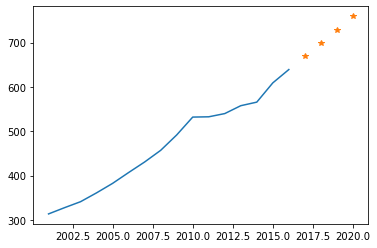

In [83]:
tot_yrs=np.arange(2020, 2000, -1)
df_prod_final=coal(df_prod,tot_yrs)
df_prod_final

In [84]:
df_prod_final=df_prod_final[df_prod_final["year"]>2010]
df_prod_final.to_csv("../Dataset/Coal_Production_2011_2020.csv",index=False)

Industrial Coal Consumption

In [85]:
df_cons=pd.read_excel("../Raw/Industrial coal consumption.xlsx",skiprows=6,usecols=[0,10],names=['year','TOT(MT)'])
df_cons.dropna(inplace=True)
df_cons['year']=np.arange(2001,2017,1)
df_cons

,year,TOT(MT)
0,2001,339.306
1,2002,349.740
2,2003,361.750
3,2004,379.400
4,2005,404.690
5,2006,395.590
6,2007,419.800
7,2008,453.570
8,2009,489.170
9,2010,513.790


,year,TOT(MT)
0,2001,339.31
1,2002,349.74
2,2003,361.75
3,2004,379.40
4,2005,404.69
5,2006,395.59
6,2007,419.80
7,2008,453.57
8,2009,489.17
9,2010,513.79


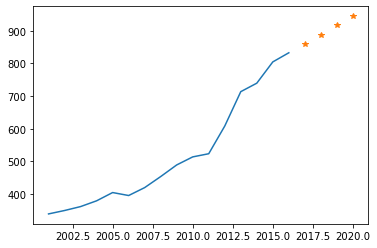

In [86]:
tot_yrs=np.arange(2020, 2000, -1)
df_cons_final=coal(df_cons,tot_yrs)
df_cons_final

In [87]:
df_cons_final=df_cons_final[df_cons_final["year"]>2010]
df_cons_final.to_csv("../Dataset/Industrial_Coal_Consumption_2011_2020.csv",index=False)